In [1]:
import torch
import numpy as np
import pandas as pd
import pickle

from hypothesis_tests import chatterjee, benjamini_hochberg, NEWCORR, COR, DCOR, HSIC, HHG, TIC

In [2]:
competitors = [
    COR,
    DCOR,
    # HSIC,
    HHG,
    TIC,
]

In [3]:
spellman = pd.read_csv("data/spellman_gene_expr_data.csv", header=0)
genes = list(spellman.columns[1:])

In [4]:
competitor_genes = torch.zeros(len(genes))
for method in competitors:
    # pvals = torch.tensor(np.genfromtxt(f"results/spellman/{method}_pvalues.txt"))
    pvals = torch.tensor(np.genfromtxt(f"results/spellman/{method}_pvalues.txt"))
    rejects_idx = benjamini_hochberg(pvals)
    print("New length:\t", len(rejects_idx))
    for i in rejects_idx:
        competitor_genes[i] = 1
    print("Total length:\t", competitor_genes.sum())
competitor_genes.sum()

New length:	 465
Total length:	 tensor(465.)
New length:	 494
Total length:	 tensor(550.)
New length:	 719
Total length:	 tensor(843.)
New length:	 291
Total length:	 tensor(853.)


tensor(853.)

In [6]:
chat_genes = torch.zeros(len(genes))
pvals = torch.zeros(len(genes))
x = torch.tensor(spellman["time"].values)
for i, gene in enumerate(genes):
    y = torch.tensor(spellman[gene].values)
    pvals[i] = chatterjee(x, y, compute_pvalue=True)[1]
rejects_idx = benjamini_hochberg(pvals)
pickle.dump(rejects_idx, open("results/spellman/chatterjee_pt_genes.pkl", "wb"))
rejects_idx = pickle.load(open("results/spellman/chatterjee_pt_genes.pkl", "rb"))
for i in rejects_idx:
    chat_genes[i] = 1

In [7]:
print(chat_genes.sum())
print(competitor_genes.sum())

tensor(586.)
tensor(853.)


In [8]:
# Genes that were selected by Chatterjee but not comptitors.
selected = torch.nn.functional.relu(chat_genes - competitor_genes)
selected.sum()

tensor(248.)

In [13]:
selected.long()[0:100]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0])

In [18]:
pvals = torch.zeros(len(genes))
x = torch.tensor(spellman["time"].values)
for i, gene in enumerate(genes):
    y = torch.tensor(spellman[gene].values)
    pvals[i] = chatterjee(x, y, compute_pvalue=True)[1]

In [27]:
sort, argsort = torch.sort(pvals[selected.bool()])
selected_idx = torch.arange(len(selected))[selected.bool()]
top_genes_idx = selected_idx[argsort][0:6]


In [28]:
top_genes = [genes[i.item()] for i in top_genes_idx]

In [29]:
top_genes

['YML058W', 'YNL283C', 'YBL003C', 'YCL014W', 'YLR462W', 'YKR010C']

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor

In [33]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['text.usetex'] = True

In [47]:
def create_ax(ax, gene):
    x = spellman["time"].to_numpy()
    y = spellman[gene].to_numpy()
    model = KNeighborsRegressor(n_neighbors=3).fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))

    ax.scatter(x, y, c="k")
    ax.plot(x, y_pred, c="k", alpha=0.3)
    ax.set_xlabel(gene)
    ax.set_xticks([])
    ax.set_yticks([])


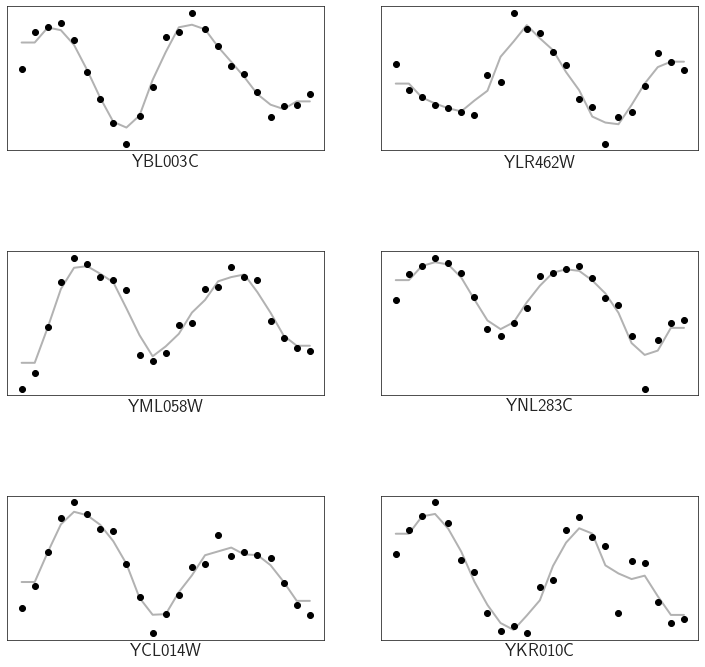

In [48]:
sns.set_style("white")

fig, ax = plt.subplots(3, 2, figsize=(12, 11))

create_ax(ax[0, 0], top_genes[2])
create_ax(ax[0, 1], top_genes[4])
create_ax(ax[1, 0], top_genes[0])
create_ax(ax[1, 1], top_genes[1])
create_ax(ax[2, 0], top_genes[3])
create_ax(ax[2, 1], top_genes[5])

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.18, 
                    hspace=0.7)
# fig.suptitle("Spellman Gene Expression Dataset")

plt.savefig("figs/spellman_gene.pdf", bbox_inches="tight")

In [8]:
lookup = {}
for i, gene in enumerate(genes):
    lookup[gene] = i

In [9]:
picked = ["YOR308C", "YJL115W", "YGR177C", "YPR119W", "YKL127W", "YHR143W"]

for gene in picked:
    print(gene)
    print(chatterjee_genes[lookup[gene]])
    print(competitor_genes[lookup[gene]])
    print("---------------------------------")

YOR308C
tensor(1.)
tensor(0.)
---------------------------------
YJL115W
tensor(1.)
tensor(0.)
---------------------------------
YGR177C
tensor(1.)
tensor(0.)
---------------------------------
YPR119W
tensor(1.)
tensor(0.)
---------------------------------
YKL127W
tensor(1.)
tensor(0.)
---------------------------------
YHR143W
tensor(1.)
tensor(0.)
---------------------------------


In [10]:
not_picked = [
    "YOR140W",
    "YCL021W",
    "YJR086W",
    "YLR406C",
    "YLR283W",
    "YOR378W",
]
for gene in not_picked:
    print(gene)
    print(chatterjee_genes[lookup[gene]])
    print(competitor_genes[lookup[gene]])
    print("---------------------------------")

YOR140W
tensor(0.)
tensor(0.)
---------------------------------
YCL021W
tensor(0.)
tensor(0.)
---------------------------------
YJR086W
tensor(0.)
tensor(1.)
---------------------------------
YLR406C
tensor(0.)
tensor(1.)
---------------------------------
YLR283W
tensor(0.)
tensor(0.)
---------------------------------
YOR378W
tensor(0.)
tensor(0.)
---------------------------------
